# Customer Retention Strategy for Model Fitness Gyms

This project aims to analyze customer retention and churn patterns at Model Fitness branches across the USA. Our objective is to conduct an in-depth examination of churned customers, identify key trends, and understand the primary reasons behind membership cancellations.

The insights from this analysis will guide the development of a comprehensive customer retention strategy designed to enhance member loyalty and address the increasing churn rates, which have emerged as a significant business concern. This strategy will reinforce our commitment to improving member retention and overall customer satisfaction.

In [1]:
# General libraries
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Sklearn libraries for algorithms, metrics, and clustering
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
)

# Display settings
pd.set_option("display.max_columns", None)

# Chart styling
sns.set(style='whitegrid')
facecolor = '#eaeaea'
font_color = '#525252'
csfont = {'fontname': 'Liberation Serif'}
hfont = {'fontname': 'LiberationSans-Regular'}

## Read Data

In [2]:
# Load and process the gym data
gym_data = pd.read_csv("gym_churn_us.csv")
gym_data.columns = gym_data.columns.str.lower()

# Display dataset shape and detailed information
print(f"Dataset contains {gym_data.shape[0]} rows and {gym_data.shape[1]} columns.")
gym_data.info()

Dataset contains 4000 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_fre

In [3]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_data.isnull().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

At first glance, the dataset appears to have no missing values, and all data has already been converted into numerical format, which will be useful for applying predictive models later in the project.

# Exploratory Data Analysis

1) **Analyze Descriptive Statistics:**
   - Use the `describe()` function to compute the mean, standard deviation, and other summary statistics for all columns.

2) **Compare Mean Feature Values by Churn Status:**
   - Utilize the `groupby()` method to examine the average values of features for customers who churned and those who did not.

3) **Visualize Feature Distributions:**
   - Create bar charts and distribution plots to compare features for churned and non-churned groups.

4) **Generate and Display Correlation Matrix:**
   - Build a correlation matrix to explore the relationships between features and visualize it with a heatmap.


In [5]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Descriptive Analysis Insights**:

Users can have contracts of either 1 month, 6 months, or up to 12 months, with the **average contract period being around 4 months**. Notably, **75% of customers leave within 6 months**. Additionally, customers attend no more than **6 classes per month**, with an **average of 1.76 classes per month**, and **75% of users attend around 2.5 classes**. The standard deviation of **1.05** suggests that most users either attend no classes or up to 2 classes. In terms of pricing, the majority of users opt for **6-month contracts**, with the **maximum charge reaching $552 per user**.


In [6]:
churn_summary = gym_data.groupby('churn').mean()[
    ['contract_period', 'age', 'avg_additional_charges_total',
     'month_to_end_contract', 'lifetime',
     'avg_class_frequency_total', 'avg_class_frequency_current_month']
]
churn_summary

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Churn Summary Insights**:

Users who churned typically remained in a gym contract for less than **2 months**, with an **average contract length of just 0.99 months**, indicating that they rarely stay beyond the first month. Despite leaving early, churned users still spent on additional services, showing a **$43 difference (27%)** compared to non-churners. On the other hand, non-churners have an **average contract period of 5.74 months** and an **average lifetime of 4.71 months**. This further reinforces the finding that **most users do not stay with the gym beyond 6 months**, aligning with the earlier insight that **75% of users have a contract duration and lifetime of 6 months or less**.

## Histogram/Distribution Analysis of Features

We will create a function that generates histograms for all features in the dataset to visually analyze their distributions.

In [7]:
columns_to_plot=['age','avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                 'avg_class_frequency_total', 'avg_class_frequency_current_month']

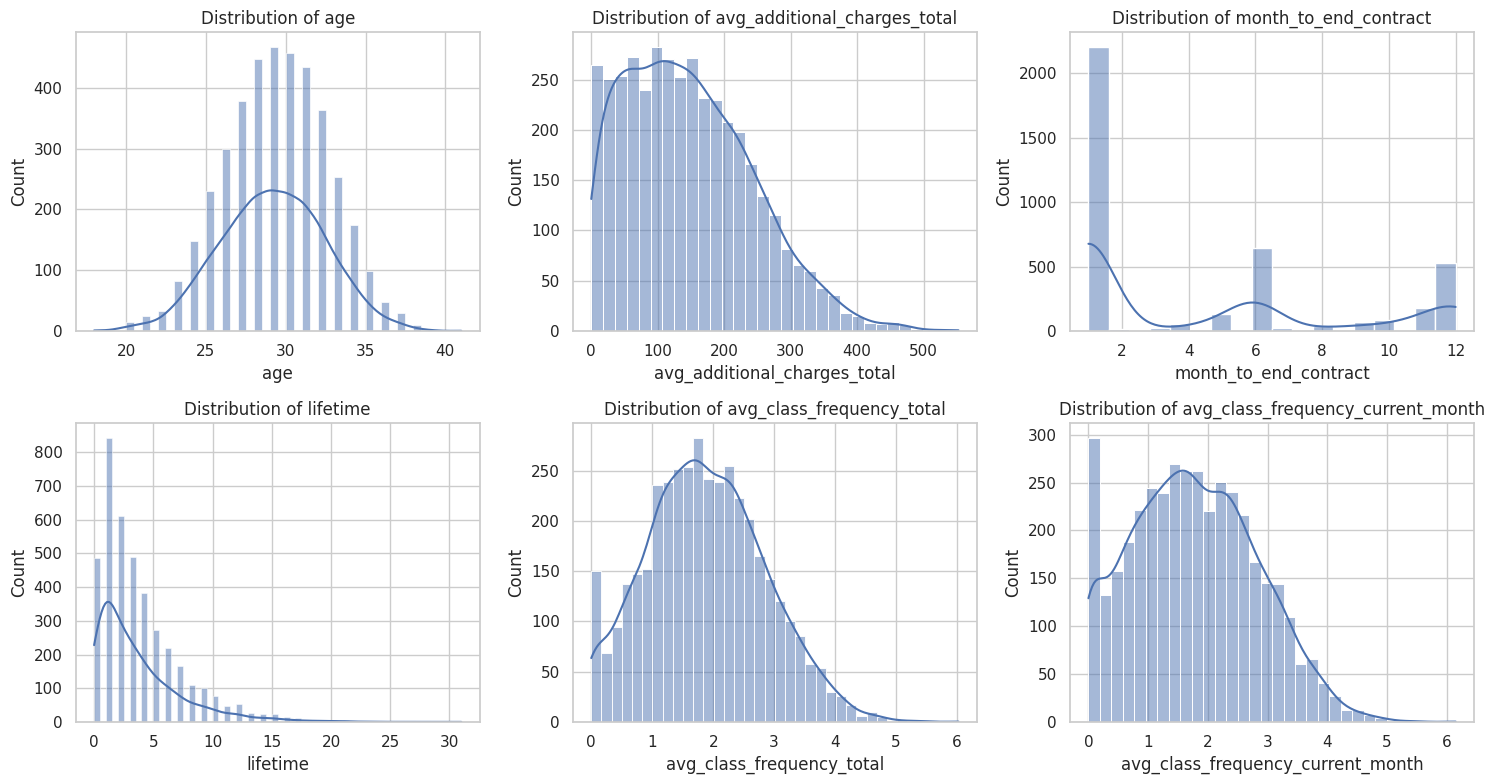

In [8]:
def plot_feature_distributions(dataframe):
    num_columns = 3
    num_features = len(dataframe.columns)
    num_rows = (num_features // num_columns) + (num_features % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(dataframe.columns):
        sns.histplot(dataframe[col], kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(gym_data[columns_to_plot])

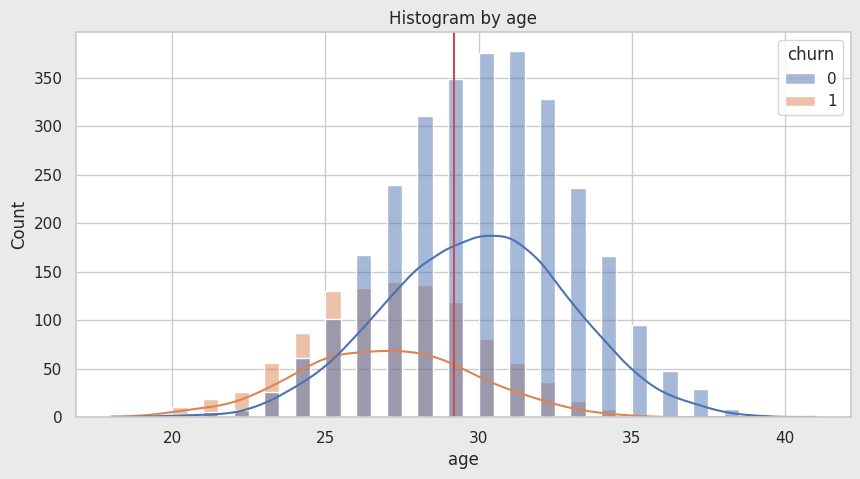

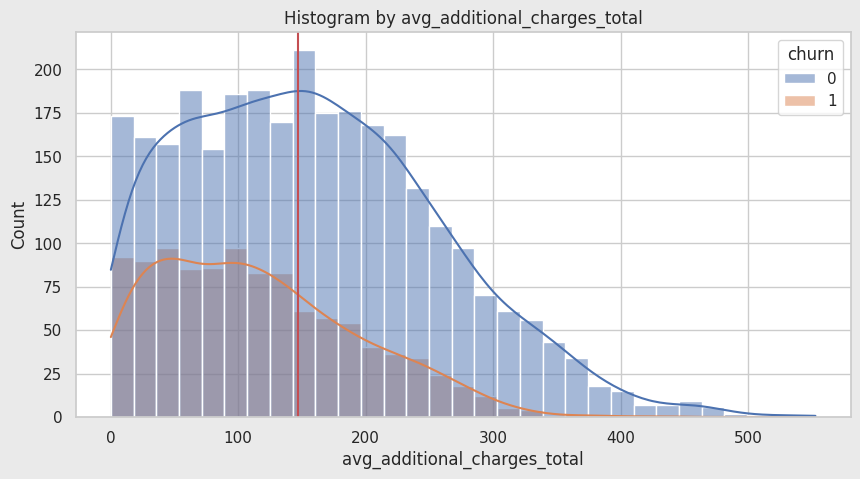

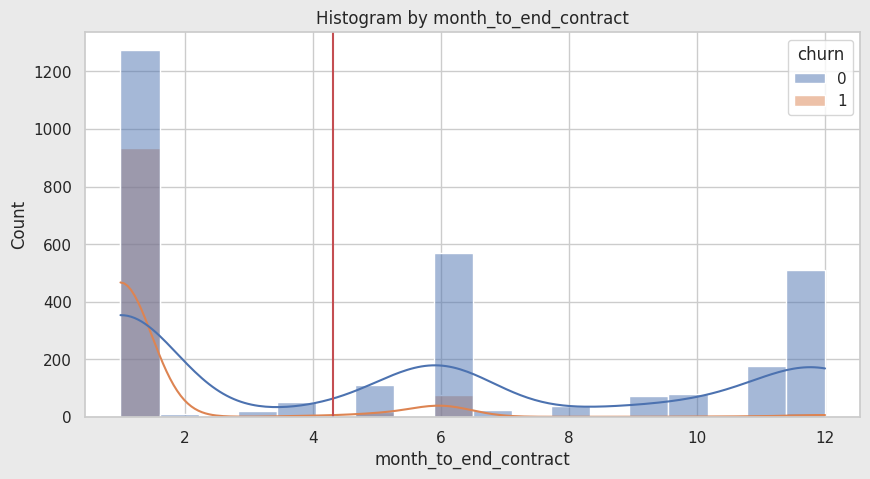

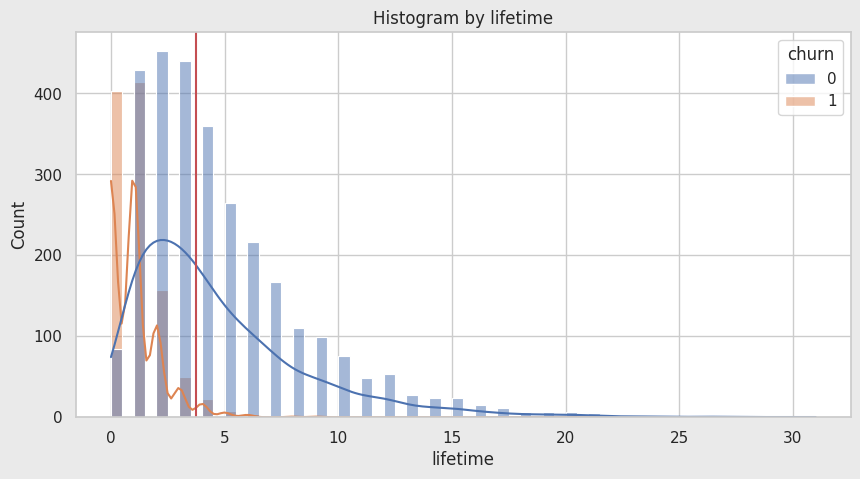

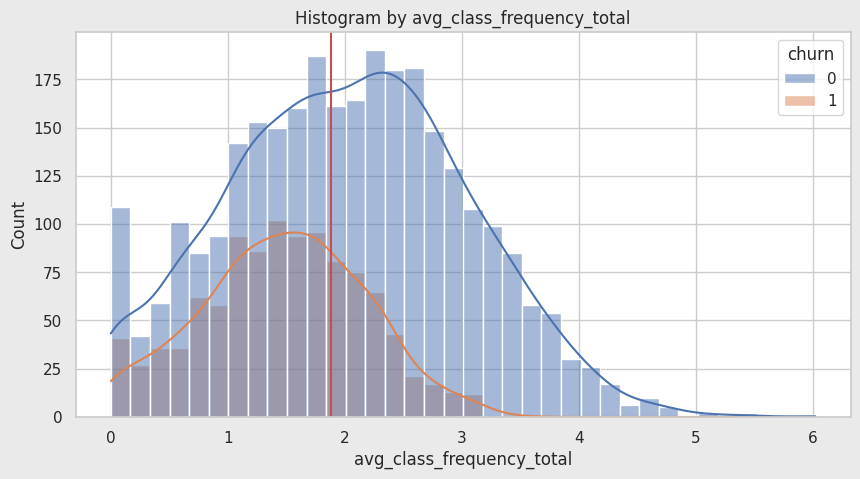

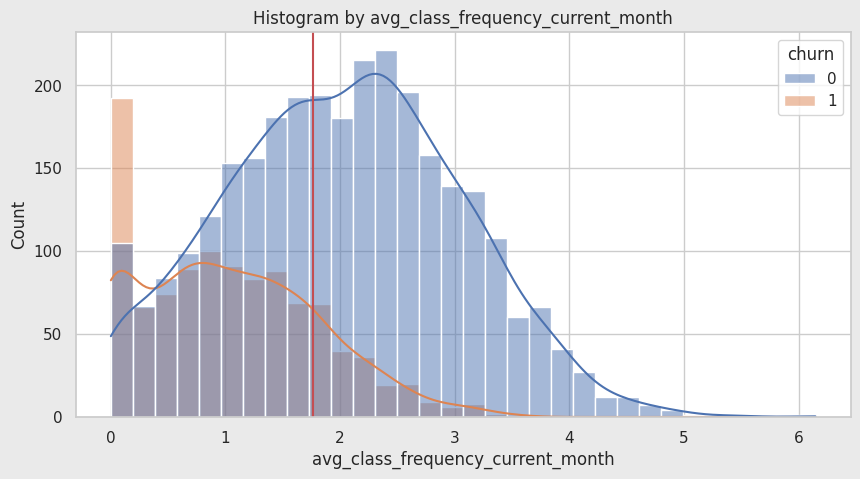

In [9]:
for col in columns_to_plot:
    mean=gym_data[col].mean()
    fig, ax = plt.subplots(figsize=(10,5),facecolor=facecolor)
    sns.histplot(data=gym_data, x=col, hue='churn', kde=True, ax=ax)
    plt.axvline(mean, color='r', linestyle='-', linewidth=1.5)
    title = f'Histogram by {col}'
    ax.set_title(title)
    plt.show()

### **More Analysis**

In [10]:
sns.set(style='whitegrid')

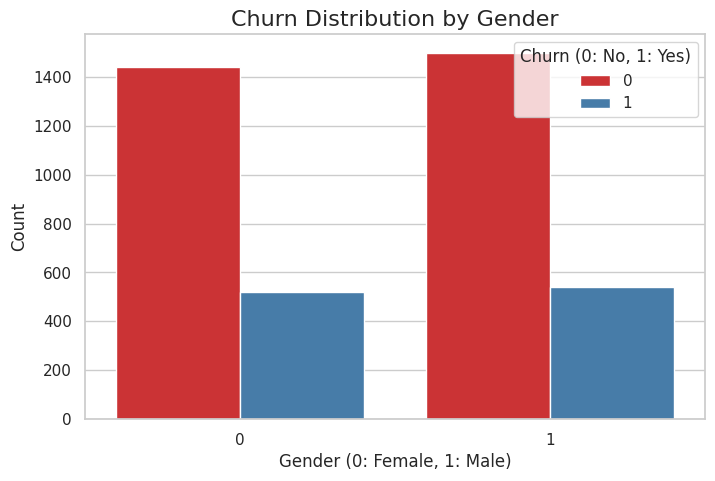

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=gym_data, x='gender', hue='churn', palette='Set1')
plt.title('Churn Distribution by Gender', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

/tmp/ipykernel_4290/1819423727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')


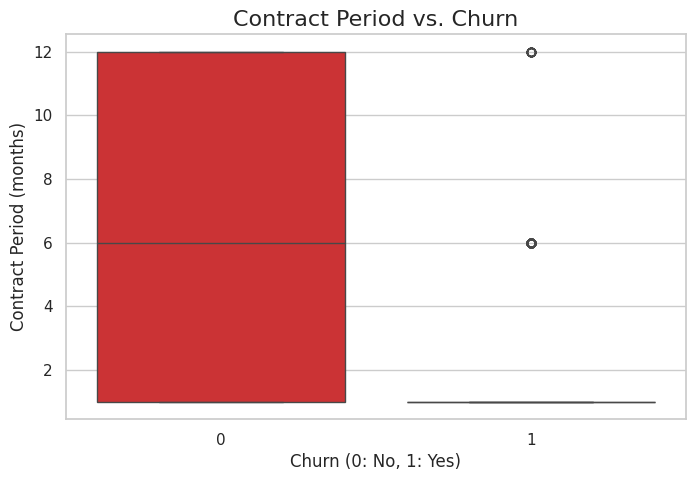

In [12]:
# Contract Period vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')
plt.title('Contract Period vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Contract Period (months)')
plt.show()

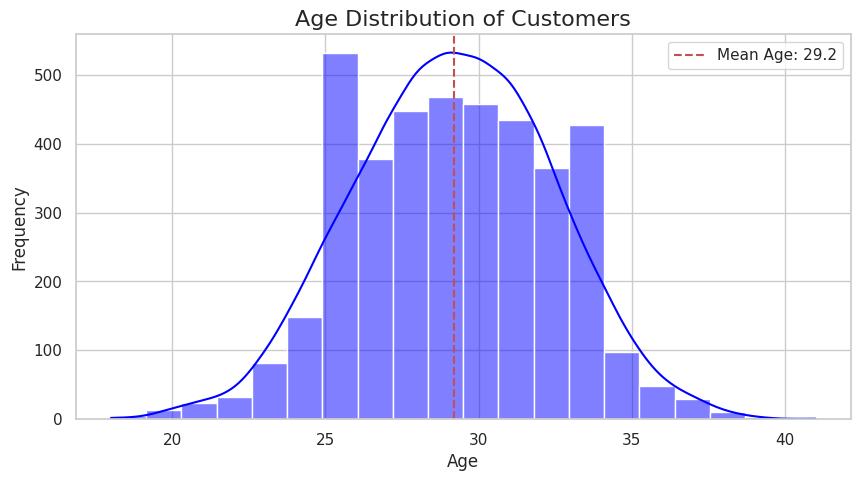

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(gym_data['age'], bins=20, kde=True, color='blue')
plt.axvline(gym_data['age'].mean(), color='r', linestyle='--', label=f'Mean Age: {gym_data["age"].mean():.1f}')
plt.title('Age Distribution of Customers', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- The plot indicates that the majority of customers are concentrated around the mid-20s to early 30s, with the mean age being approximately **29.2 years**.

- The distribution is somewhat right-skewed, indicating a few older customers.

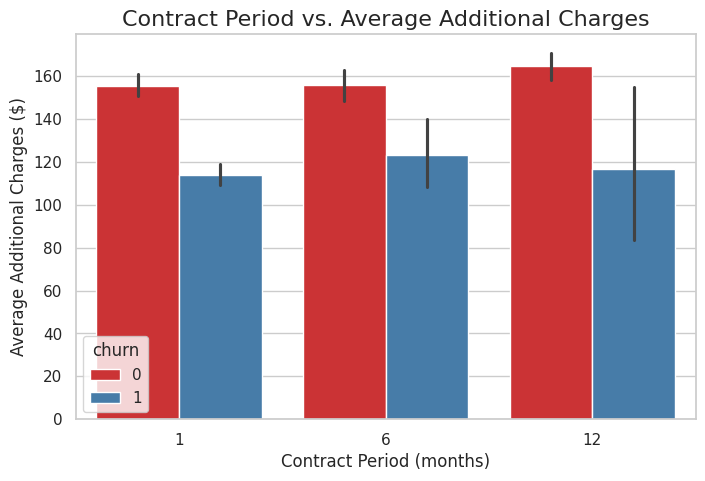

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(data=gym_data, x='contract_period', y='avg_additional_charges_total', hue='churn', palette='Set1')
plt.title('Contract Period vs. Average Additional Charges', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Average Additional Charges ($)')
plt.show()

- **Shorter Contracts (1 month):** Customers with a 1-month contract who do not churn tend to spend significantly more on additional charges than those who churn. This suggests that non-churned users on short-term contracts might be highly engaged and willing to spend more.

- **Longer Contracts (6 and 12 months):** Non-churned customers in both the 6-month and 12-month contracts also tend to spend more than churned customers. Interestingly, there’s a notable drop in additional charges for churned customers across all contract durations, indicating that disengaged customers contribute less financially beyond their base contract.

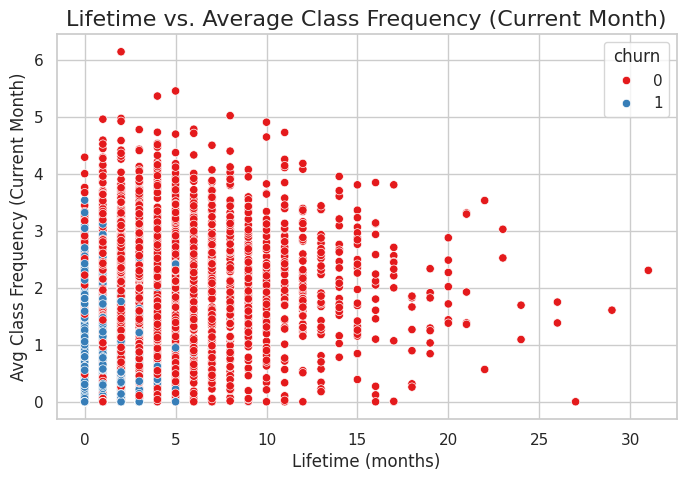

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=gym_data, x='lifetime', y='avg_class_frequency_current_month', hue='churn', palette='Set1')
plt.title('Lifetime vs. Average Class Frequency (Current Month)', fontsize=16)
plt.xlabel('Lifetime (months)')
plt.ylabel('Avg Class Frequency (Current Month)')
plt.show()

- **Churned Customers:**
    
    Many of the churned customers (blue points) appear concentrated around a shorter lifetime (0–6 months) and lower class frequency, suggesting that customers who attend fewer classes and have shorter memberships tend to churn more frequently.

- **Non-Churned Customers:**

    The red points (non-churned customers) are spread across longer lifetimes and higher class frequencies, indicating more consistent gym usage over time.

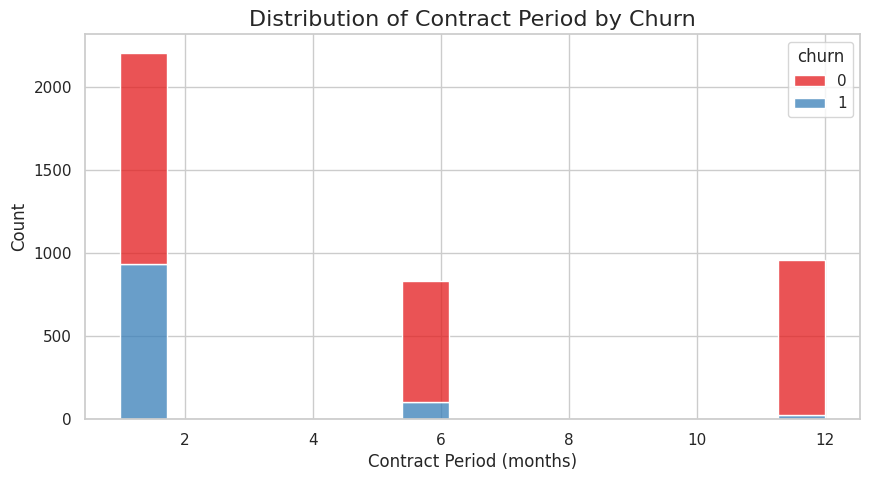

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(data=gym_data, x='contract_period', hue='churn', multiple='stack', palette='Set1', bins=15)
plt.title('Distribution of Contract Period by Churn', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Count')
plt.show()

- **Short-Term Contracts (1 month):**

    The plot reveals that most churned customers (blue) are concentrated within the 1-month contract period. This suggests that shorter contracts are highly correlated with churn.

- **Medium-Term and Long-Term Contracts (6 and 12 months):**

    Customers with 6-month and 12-month contracts are much less likely to churn. Almost all customers with these longer contract periods do not churn (red).

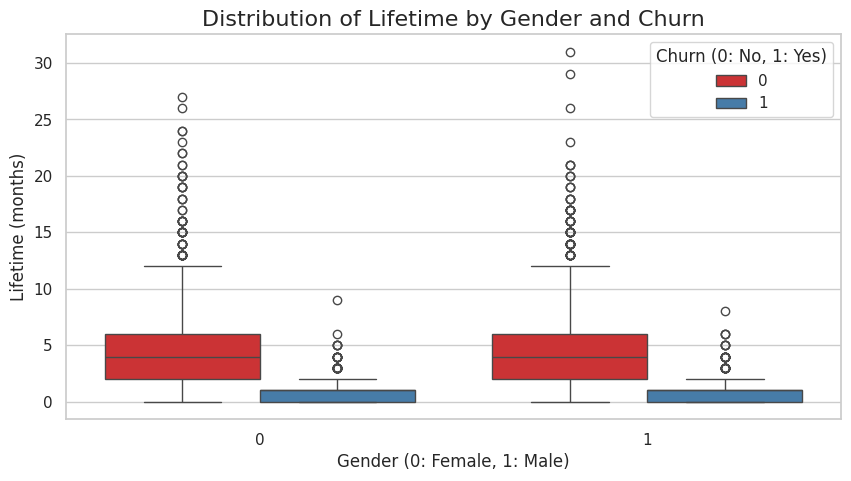

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=gym_data, x='gender', y='lifetime', hue='churn', palette='Set1')
plt.title('Distribution of Lifetime by Gender and Churn', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Lifetime (months)')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

- **Non-Churned Customers:**

    Both male and female customers who did not churn (red boxes) tend to have longer lifetimes, with medians close to 5 months. The spread for non-churned customers is wider, indicating greater variability in lifetime, with some customers remaining for more than 20 months.

- **Churned Customers:**

    Churned customers (blue boxes) have much shorter lifetimes, typically less than 1–2 months for both genders. The spread is narrower, and the presence of outliers indicates that a few churned customers had relatively longer lifetimes.

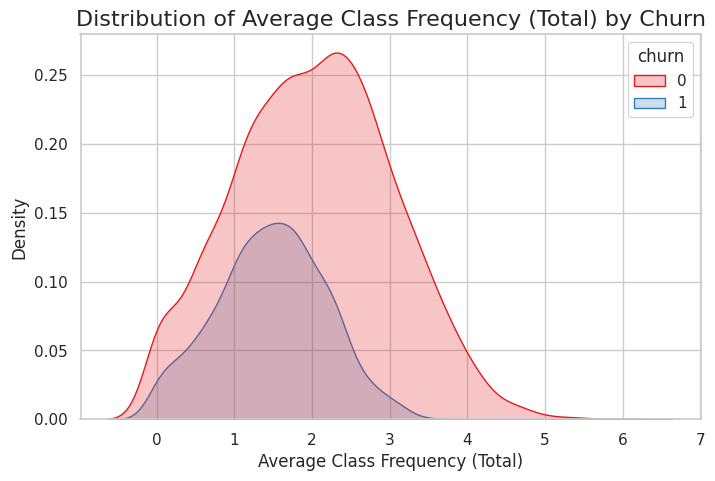

In [18]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=gym_data, x='avg_class_frequency_total', hue='churn', fill=True, palette='Set1')
plt.title('Distribution of Average Class Frequency (Total) by Churn', fontsize=16)
plt.xlabel('Average Class Frequency (Total)')
plt.ylabel('Density')
plt.show()

- **Non-Churned Customers (red curve):**

    Non-churned customers tend to have a higher average class frequency, peaking around 2–3 classes per month. This indicates that customers who attend classes more frequently are less likely to churn.

- **Churned Customers (blue curve):**

    The blue curve shows that churned customers generally have lower average class attendance, with a peak around 1 class per month or fewer.

/tmp/ipykernel_4290/4270430277.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')


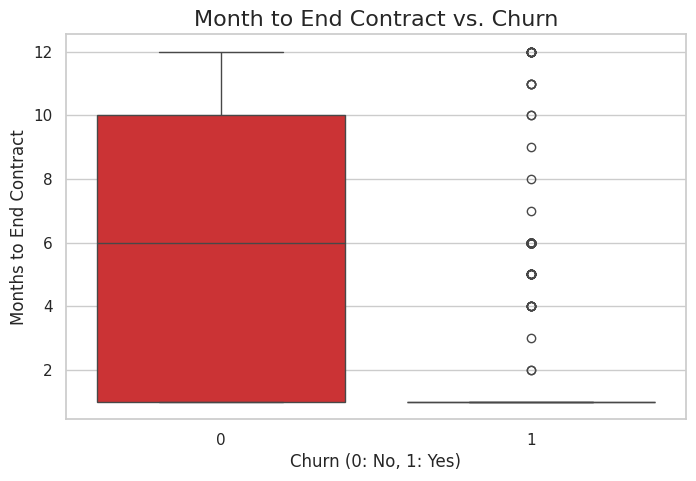

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')
plt.title('Month to End Contract vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Months to End Contract')
plt.show()

- **Non-Churned Customers (0):**

    Non-churned customers generally have more months remaining on their contracts, with a median around 6 months. The distribution also shows a wide range of remaining months (with some customers having up to 12 months left).

- **Churned Customers (1):**
    
    Churned customers tend to have very few months left on their contracts, with a median close to zero. This suggests that customers who are close to the end of their contracts are much more likely to churn.